This exercise is to cluster seeds according to a 1-NN algorithm, using holdout sets to create training and test data. it impelements the nearest neighbour from scratch instead of using scikit-learn.

# Script

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as req
from io import StringIO
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from matplotlib.colors import ListedColormap
% matplotlib inline

In [2]:
#set number of folds for cross validation
num_folds=5

#set uri for data source
url = 'https://raw.github.com/luispedro/BuildingMachineLearningSystemsWithPython/master/ch02/data/seeds.tsv'

In [3]:
#Store data in a StringIO object which mimics a file
response = req.get(url)
bytesstr = response.content
sio = StringIO()
sio.write(bytesstr.decode(response.encoding))
sio.seek(0)

0

In [4]:
#Read the features and label into an array each
data = []
target = []
lines = [line.strip() for line in sio.readlines()]
for line in lines:
    tokens = line.split('\t')
    target.append(tokens[-1])
    data.append([float(t) for t in tokens[:-1]])
X = normalize(np.array(data)) #Store features as X
Y = np.array(target) #Store labels/targets as Y
data = np.array(data) #Store data as numpy array for ease

In [5]:
#returns the label of the nearest neighbour
def get_nearest_neighbour(test_point,train_features,train_labels):
    distances = [euclidean(test_point,tf) for tf in train_features]
    closest = np.array(distances).argmin()
    return train_labels[closest]

In [6]:
#across each holdout set calculate model accuracy
NNs = []
model_accuracies = []
for fold in range(num_folds):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=1.0/num_folds)
    NNs = [get_nearest_neighbour(data_point,X_train,Y_train) for data_point in X_test]
    accuracy =[1 if nn==y_tst else 0 for nn, y_tst in zip(NNs,Y_test)]
    model_accuracies.append(np.mean(accuracy))
model_accuracies, 'Mean accuracy is %4.4f' % np.mean(model_accuracies)

([0.95238095238095233,
  0.8571428571428571,
  0.8571428571428571,
  0.8571428571428571,
  0.9285714285714286],
 'Mean accuracy is 0.8905')

Let's have a look at a plot of nearest-neighbour using two dimensions, say area and compactness, indexed by 0 and 2 respectively in the data 

In [9]:
#create a set of points to plot
plt_features = data[:,(0,2)]

#set colour maps for existing features and predicted labels  
feature_cmap = ListedColormap([(1., .0, .0), (.0, 1., .0), (.0, .0, 1.)])
prediction_cmap = ListedColormap([(1., .6, .6), (.6, 1., .6), (.6, .6, 1.)])

#map predictions to numeric labels for colormap
colmapper = {'Canadian':1,'Kama':2,'Rosa':3}

# Visualisation
Create a function to plot the 1-NN algorithm visually

In [10]:
def plotNN(NN_function,features,Xname,Yname,target,predCMap,featCMap,colourmapper):
    
    #create grid values to plot
    df = pd.DataFrame(features)
    try:
        xmin, ymin = df.apply(min,axis=0)
        xmax, ymax = df.apply(max,axis=0)
        X = np.linspace(xmin*0.9,xmax*1.1,100)
        Y = np.linspace(ymin*0.9,ymax*1.1,100)
        X,Y = np.meshgrid(X,Y)
        gridvals = np.vstack([X.ravel(),Y.ravel()]).T
    except ValueError as e:
        print(e)
    
    #Predict nearest neighbour of each grid point
    predictions = [get_nearest_neighbour(dp,features,target) for dp in gridvals]
    predicted_labels = list(map(colmapper.get,predictions))
    target_labels = list(map(colmapper.get,target))
    
    #set up plot
    fig, ax = plt.subplots()
    ax.set_xlim(X.min(),X.max())
    ax.set_ylim(Y.min(),Y.max())
    ax.set_xlabel(Xname)
    ax.set_ylabel(Yname)
    
    #plot mesh and scatter
    ax.pcolormesh(X,Y,np.array(predicted_labels).reshape(X.shape),cmap=prediction_cmap)
    ax.scatter(features[:, 0], features[:, 1], c=target_labels, cmap=feature_cmap)
    plt.show()

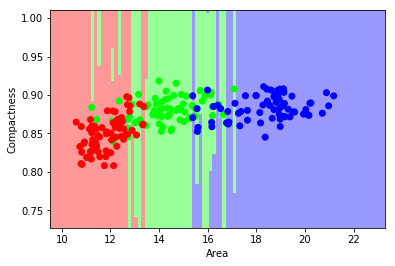

In [11]:
plotNN(get_nearest_neighbour,plt_features,'Area','Compactness',target,prediction_cmap,feature_cmap,colmapper)

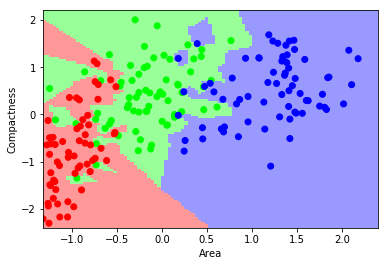

In [12]:
norm_plt_features = (plt_features - plt_features.mean(axis=0))/plt_features.std(axis=0)
plotNN(get_nearest_neighbour,norm_plt_features,'Area','Compactness',target,prediction_cmap,feature_cmap,colmapper)